[![https://gyazo.com/4c20b38b3c25155465c9a9a1440c47b2](https://i.gyazo.com/4c20b38b3c25155465c9a9a1440c47b2.png)](https://gyazo.com/4c20b38b3c25155465c9a9a1440c47b2)

## Predict Credit Card Default - Modelling


                                                          Pau Roger Puig-Sureda
                                                          08/06/2018

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn import linear_model
import tensorflow as tf
from  keras.models  import Sequential
from keras.layers.core import Dense, Activation, Dropout
import xgboost as xgb
from xgboost import XGBClassifier
import gc
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


### Import Data

In [3]:
train = pd.read_csv('challengeTrain.csv')
data = pd.read_csv('cleaned_data.csv')
data.head(3)

,age,channel,indBadDebt,indBadLocation,indCreditBureau,indInternet,indSimin,indXlist,numLoans,numMortgages,previous,salary,sex,status,target,binned_externalScore,binned_ExternalDefault,2_or_more_acc
0,23.0,External Agent,1,0,0,1,0,0,Unknown,Unknown,Normal,1200,0,Single,1.0,1.0,1.0,0
1,27.0,External Agent,0,0,0,1,1,0,1.0,0.0,Restructuring,1750,1,Single,0.0,3.0,3.0,0
2,28.0,External Agent,0,0,0,1,0,0,2.0,0.0,Restructuring,1750,1,Single,1.0,3.0,3.0,0


In [4]:
data.describe()

,age,indBadDebt,indBadLocation,indCreditBureau,indInternet,indSimin,indXlist,salary,sex,target,binned_ExternalDefault,2_or_more_acc
count,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,522939.000000,697252.000000,697252.000000
mean,38.769474,0.290760,0.169547,0.042372,0.775035,0.098779,0.053629,1507.275849,0.372502,0.340265,2.384058,0.027918
std,13.753097,0.454113,0.375235,0.201437,0.417559,0.298366,0.225284,1059.008536,0.483471,0.473799,0.961865,0.164739
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1200.000000,0.000000,0.000000,1.000000,0.000000
50%,36.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1200.000000,0.000000,0.000000,3.000000,0.000000
75%,47.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1400.000000,1.000000,1.000000,3.000000,0.000000
max,111.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9000.000000,1.000000,1.000000,3.000000,1.000000


In [5]:
target = data['target']

In [6]:
target.isnull().sum()

174313

In [7]:
data.shape

(697252, 18)

In [8]:
data.head()

,age,channel,indBadDebt,indBadLocation,indCreditBureau,indInternet,indSimin,indXlist,numLoans,numMortgages,previous,salary,sex,status,target,binned_externalScore,binned_ExternalDefault,2_or_more_acc
0,23.0,External Agent,1,0,0,1,0,0,Unknown,Unknown,Normal,1200,0,Single,1.0,1.0,1.0,0
1,27.0,External Agent,0,0,0,1,1,0,1.0,0.0,Restructuring,1750,1,Single,0.0,3.0,3.0,0
2,28.0,External Agent,0,0,0,1,0,0,2.0,0.0,Restructuring,1750,1,Single,1.0,3.0,3.0,0
3,45.0,Call Center,0,0,0,0,0,0,1.0,0.0,Unpaid,1200,1,Single,1.0,3.0,3.0,0
4,28.0,External Agent,0,0,0,1,0,0,Unknown,Unknown,Normal,850,0,Unknown,0.0,3.0,3.0,0


**dataNT** is a new dataframe without the target variable, since it is the only variable that I do not want to neither dummify it nor normalize it.

In [9]:
dataNT = data.drop(columns='target')
dataNT.shape

(697252, 17)

Making sure that there are no remainning NA's and the target variable is not present.

In [10]:
dataNT.isnull().sum()

age                       0
channel                   0
indBadDebt                0
indBadLocation            0
indCreditBureau           0
indInternet               0
indSimin                  0
indXlist                  0
numLoans                  0
numMortgages              0
previous                  0
salary                    0
sex                       0
status                    0
binned_externalScore      0
binned_ExternalDefault    0
2_or_more_acc             0
dtype: int64

With the next bit of code I will dummify all the factor variables.

In [11]:
dummy_data = pd.get_dummies(dataNT)

In [12]:
dummy_data.shape

(697252, 52)

After doing so, I go from 17 features to 52.

#### Normalize Data

In [13]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

In [14]:
data = feature_normalize(dummy_data)
data.shape

(697252, 52)

Once the factor dummies are inputted and all the variables normalized, I reattach the target variable to the dataset.

In [15]:
data = dummy_data.join(target)
data.shape

(697252, 53)

### Split dataset again into train and test

In [16]:
ctrain = data[data['target'].notnull()]
ctest = data[data['target'].isnull()]

A model that would output all zeros would have an accuracy of a little over **66%**, which makes it a pretty difficult task for the next classifiers. However let's see how they perform.

I will point out that, in these problems where most of the instances are in one category the **accuracy** is not the best evaluation metric, instead I will focus on the area under the curve (**auc**).

#### Functions for Evaluation of the model.

In [17]:
def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

## Modeling

First, I will split the trainning set into **train** ('X' and 'y' train) and **validation** ('X' and 'y' test).

In [18]:
X_train, X_test, y_train, y_test = train_test_split(ctrain.drop('target',axis=1), ctrain['target'], random_state=111, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(418351, 52) (418351,)
(104588, 52) (104588,)


I tried to apply the SMOTEENN function to balance the trainning dataset, which returned a staggering 95% AUC. However, the unavailability of doing transformations on the test dataset set makes the model very overfitted and not useful for predictions.

In [19]:
#Apply SMOTEENN technique to balance dataset
#se = SMOTEENN(random_state=12, ratio = 'auto')
#x_train_res, y_train_res = se.fit_sample(Train, np.ravel(Target))

### Logistic Regression / Model Baseline

In [20]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [21]:
cross_val_score(logreg, X_test, y_test, scoring='roc_auc')

array([0.69651288, 0.69983355, 0.69338514])

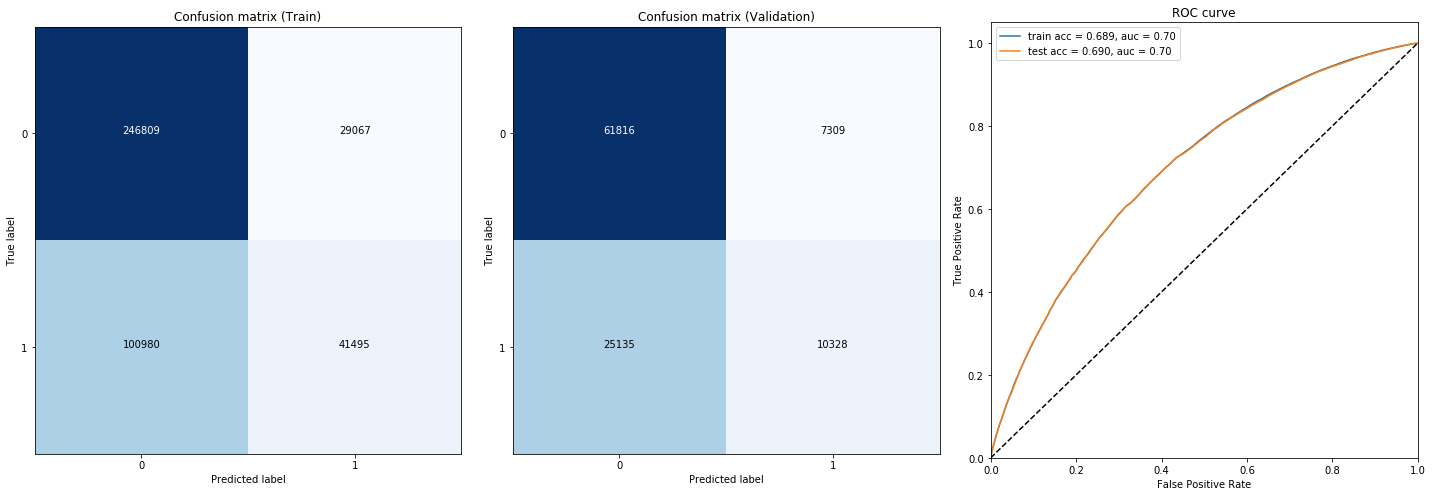

In [22]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = logreg.predict_proba(X_train)[:,1]
y_test_pred = logreg.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(20,7)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (Train)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (Validation)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

The logistic regression outputs almost 70% of the instances under the curve. Let's see if more complex models are able to beat this.

### Random Forest

In [23]:
rf = RandomForestClassifier()

In [24]:
parameter_dist = dict(n_estimators=[176,177,178,179,180,185],
                     max_features=['log2', 'sqrt'],
                     min_samples_split=[173,174,175,176,180,185],
                     n_jobs=[-1])

In [25]:
ccc = RandomizedSearchCV(rf, param_distributions = parameter_dist, n_iter=32)

ccc.fit(X_train, y_train)

ccc.best_params_

{'n_jobs': -1,
 'n_estimators': 180,
 'min_samples_split': 176,
 'max_features': 'sqrt'}

In [26]:
ccc.best_score_.round(6)

0.698602

Optimized with previous calculated parameters.

In [27]:
clf = RandomForestClassifier(n_estimators = 179, n_jobs = -1, max_features = 'sqrt', min_samples_split = 176)

Fitting the model.

In [28]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=176,
            min_weight_fraction_leaf=0.0, n_estimators=179, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
cross_val_score(clf, X_test, y_test, scoring='roc_auc')

array([0.70812597, 0.71087511, 0.70497345])

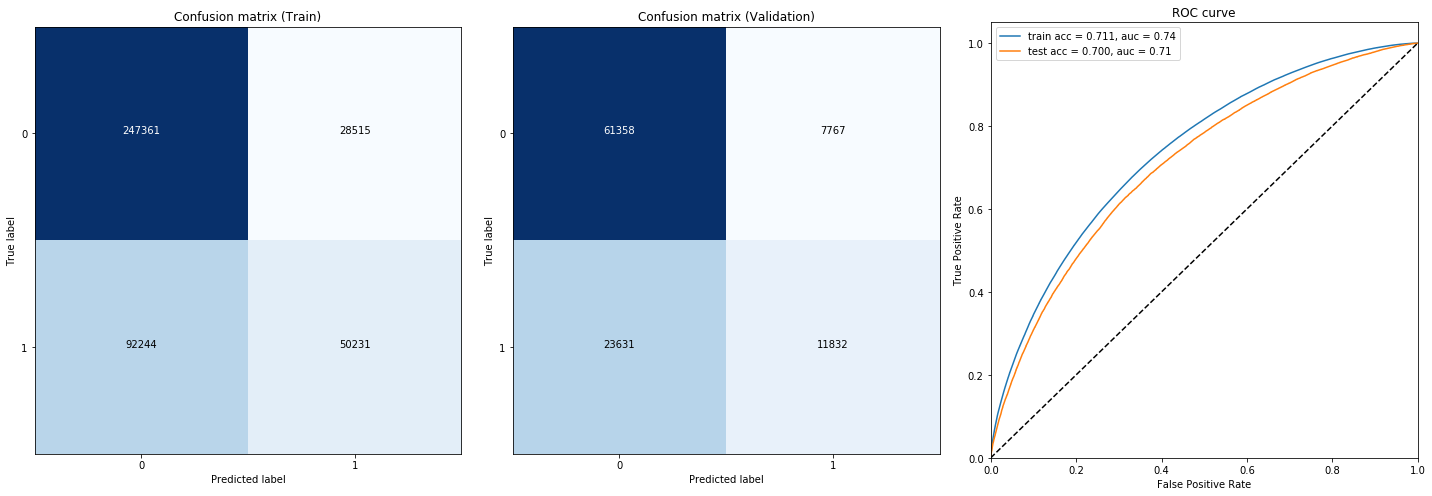

In [30]:
threshold = 0.5
y_train_pred = clf.predict_proba(X_train)[:,1]
y_test_pred = clf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(20,7)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (Train)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (Validation)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

A little improvement is seen when applyig RF, also note that the fact that the lines on the ROC curve are a bit separated indicates a little overfitting. 

Let's try again with another classifier.

### XGBoost

When only the subset of 10% of the data was uploaded I tried several options for each parameter, the ones below are the ones that returned the better score.

In [31]:
param_test2 = {
 'learning_rate':[0.1],
 'subsample':[0.8],
 'colsample_bytree':[0.79],
 'max_depth':[3],
 'min_child_weight':[4],
 'gamma':[0.01],
 'objective':[ 'binary:logistic'],
 'n_estimators':[250],
 'nthread':[1],
 'scale_pos_weight':[1]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(seed=27), 
                                                  param_grid = param_test2, 
                                                  scoring='roc_auc',
                                                  n_jobs=2,iid=False, 
                                                  cv=5)

In [32]:
gsearch2.fit(X_train,y_train, verbose=True)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_ 

({'mean_fit_time': array([105.6217257]),
  'std_fit_time': array([7.45783976]),
  'mean_score_time': array([0.63609982]),
  'std_score_time': array([0.06307549]),
  'param_colsample_bytree': masked_array(data=[0.79],
               mask=[False],
         fill_value='?',
              dtype=object),
  'param_gamma': masked_array(data=[0.01],
               mask=[False],
         fill_value='?',
              dtype=object),
  'param_learning_rate': masked_array(data=[0.1],
               mask=[False],
         fill_value='?',
              dtype=object),
  'param_max_depth': masked_array(data=[3],
               mask=[False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4],
               mask=[False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[250],
               mask=[False],
         fill_value='?',
              dtype=object),
  'param_nthread': masked_array(data=[1],
      

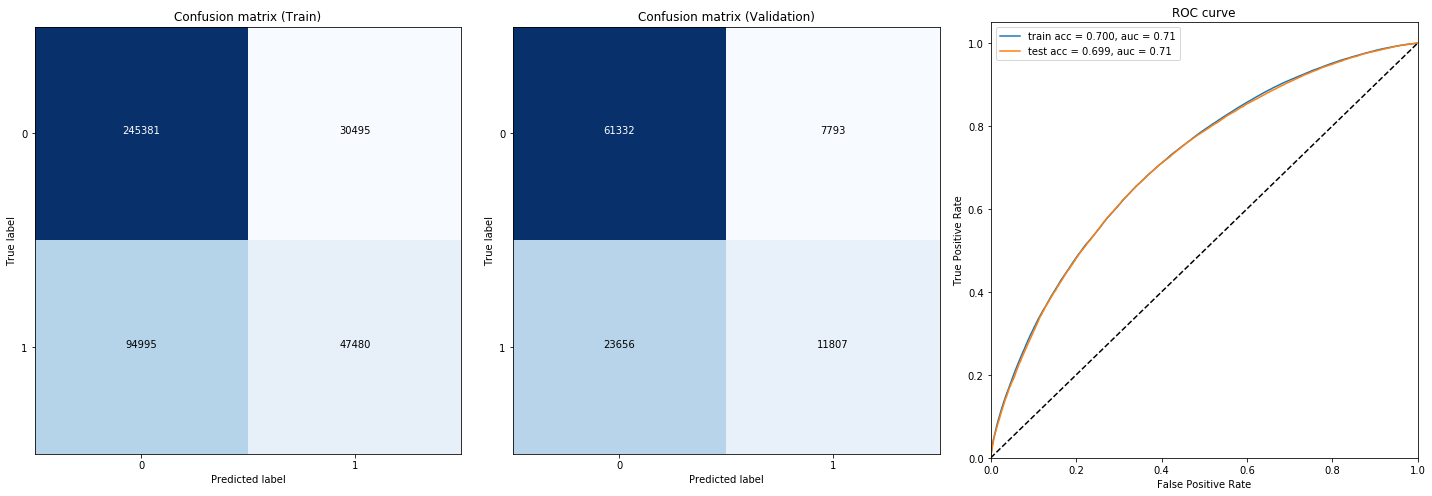

In [33]:
threshold = 0.5
y_train_pred = gsearch2.predict_proba(X_train)[:,1]
y_test_pred = gsearch2.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(20,7)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (Train)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (Validation)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

In [34]:
cross_val_score(gsearch2, X_test, y_test, scoring='roc_auc')

array([0.7099452 , 0.71369844, 0.70761155])

Again a little improvement on the previous models and this one is less prone to overfitting.

### SVM

In [35]:
#from sklearn import svm
#svm_clf = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, tol=0.001, 
#                  cache_size=200, class_weight=None, verbose=True, max_iter=-1, decision_function_shape='ovr', random_state=None)
  

In [36]:
#svm_clf.fit(X_train, y_train)

In [37]:
#cross_val_score(svm_clf, X_test, y_test, scoring='roc_auc')

In [38]:
#threshold = 0.5
#y_train_pred = svm_clf.predict_proba(X_train)[:,1]
#y_test_pred = svm_clf.predict_proba(X_test)[:,1]

#fig,ax = plt.subplots(1,3)
#fig.set_size_inches(20,7)

#plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (Train)', threshold)
#plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (Validation)', threshold)
#plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
#plt.tight_layout()
#plt.show()

I also tried to run SVM, however it takes a very LONG time to run, this is why I could only see the output with the subset of 10% of the data.

Seeing the non-exciting results, I also tried to run a simple **Feed Forward Deep Neural Net** to see if there could be improvement.

### Tensorflow / Keras

In [39]:
from keras.models import Sequential
from keras.layers import Dense

data.shape

(697252, 53)

Splitting the data into X and Y - input and output 

In [40]:
array = ctrain.values
X = array[:, 0:51]
Y = array[:, 52]

print(X.shape)
print(Y.shape)

(522939, 51)
(522939,)


Defining the model using **Sequential()** with 2 hidden layers, 51 Inputs and 1 Output.

**Relu** and **Signmoid** are used as activation functions here initialised with uniform weights. 

In [41]:
model = Sequential()
model.add(Dense(51, input_dim = 51, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(8, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

Compliling the model defining the loss function, optimizer used and metric to be calculated. 

In [42]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Fit the model.

In [43]:
model.fit(X, Y, epochs = 300, batch_size = 25, verbose = 1)

Epoch 1/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5944 - acc: 0.6846
Epoch 2/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5877 - acc: 0.6901
Epoch 3/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5859 - acc: 0.6911
Epoch 4/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5847 - acc: 0.6916
Epoch 5/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5839 - acc: 0.6927
Epoch 6/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5837 - acc: 0.6925
Epoch 7/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5833 - acc: 0.6934
Epoch 8/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5829 - acc: 0.6934
Epoch 9/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5827 - acc: 0.6935
Epoch 10/300
522939/522939 [==============================] - 19

522939/522939 [==============================] - 20s 37us/step - loss: 0.5802 - acc: 0.6955
Epoch 80/300
522939/522939 [==============================] - 20s 39us/step - loss: 0.5805 - acc: 0.6957
Epoch 81/300
522939/522939 [==============================] - 19s 37us/step - loss: 0.5813 - acc: 0.6952
Epoch 82/300
522939/522939 [==============================] - 19s 37us/step - loss: 0.5808 - acc: 0.6957
Epoch 83/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5801 - acc: 0.6956
Epoch 84/300
522939/522939 [==============================] - 19s 37us/step - loss: 0.5801 - acc: 0.6961
Epoch 85/300
522939/522939 [==============================] - 19s 37us/step - loss: 0.5801 - acc: 0.6960
Epoch 86/300
522939/522939 [==============================] - 20s 39us/step - loss: 0.5801 - acc: 0.6958
Epoch 87/300
522939/522939 [==============================] - 19s 37us/step - loss: 0.5801 - acc: 0.6960
Epoch 88/300
522939/522939 [==============================] - 20s 38

522939/522939 [==============================] - 18s 34us/step - loss: 0.5800 - acc: 0.6955
Epoch 157/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5800 - acc: 0.6958
Epoch 158/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5801 - acc: 0.6960
Epoch 159/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5798 - acc: 0.6961
Epoch 160/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5800 - acc: 0.6957
Epoch 161/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5800 - acc: 0.6959
Epoch 162/300
522939/522939 [==============================] - 18s 34us/step - loss: 0.5798 - acc: 0.6960
Epoch 163/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5799 - acc: 0.6960
Epoch 164/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5799 - acc: 0.6959
Epoch 165/300
522939/522939 [==============================]

522939/522939 [==============================] - 19s 36us/step - loss: 0.5801 - acc: 0.6957
Epoch 234/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5804 - acc: 0.6957
Epoch 235/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5800 - acc: 0.6957
Epoch 236/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5800 - acc: 0.6956
Epoch 237/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5800 - acc: 0.6960
Epoch 238/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5803 - acc: 0.6956
Epoch 239/300
522939/522939 [==============================] - 18s 35us/step - loss: 0.5799 - acc: 0.6956
Epoch 240/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5800 - acc: 0.6960
Epoch 241/300
522939/522939 [==============================] - 19s 36us/step - loss: 0.5799 - acc: 0.6961
Epoch 242/300
522939/522939 [==============================]

# Submission

Finally I will create the submission files in csv format.

**submission** -> XGBoost_Binnary

**submission2** -> XGBoost_Probability

**submission3** -> Keras_Probability

In [44]:
xgboost_clf = gsearch2.fit(ctrain.drop('target',axis=1), ctrain['target'])

In [45]:
train_features = ctest

In [46]:
del train_features['target']

In [47]:
train_features.head()

,age,indBadDebt,indBadLocation,indCreditBureau,indInternet,indSimin,indXlist,salary,sex,binned_ExternalDefault,...,status_Married,status_Single,status_Unknown,status_Widower,binned_externalScore_0.0,binned_externalScore_1.0,binned_externalScore_2.0,binned_externalScore_3.0,binned_externalScore_4.0,binned_externalScore_Unknown
522939,26.0,0,0,0,1,0,0,1400,0,3.0,...,0,1,0,0,0,0,1,0,0,0
522940,20.0,0,0,0,1,0,0,350,0,3.0,...,0,1,0,0,0,0,0,1,0,0
522941,63.0,0,0,0,0,0,0,1400,1,3.0,...,0,1,0,0,0,0,0,0,1,0
522942,32.0,0,1,0,0,0,0,1200,1,3.0,...,0,1,0,0,0,0,0,1,0,0
522943,23.0,1,0,0,1,0,0,1400,1,1.0,...,0,1,0,0,0,0,1,0,0,0


In [48]:
prediction = gsearch2.predict(train_features)

In [49]:
prediction

array([0., 1., 0., ..., 0., 1., 0.])

In [51]:
ctest["ID"] = range(1, len(ctest) + 1)

In [52]:
# Dataframe as per submission format
submission = pd.DataFrame({
            "Id": ctest["ID"],
            "Prediction": prediction
        })

In [53]:
# Store submission dataframe into file
submission.to_csv("XGBoost_Binary.csv", index = False)

In [54]:
submission.head()

,Id,Prediction
522939,1,0.0
522940,2,1.0
522941,3,0.0
522942,4,0.0
522943,5,0.0


In [55]:
del train_features['ID']

In [56]:
prediction2 = gsearch2.predict_proba(train_features)

In [57]:
prediction2.shape

(174313, 2)

In [58]:
prediction2 = np.delete(prediction2,np.s_[0],axis=1)

In [59]:
train_features['id'] = range(1, len(prediction2) + 1)

In [60]:
submission2 = pd.DataFrame(train_features['id'])

In [61]:
submission2['Prediction'] = prediction2

In [62]:
submission2.shape

(174313, 2)

In [63]:
submission2.head()

,id,Prediction
522939,1,0.210781
522940,2,0.570712
522941,3,0.130256
522942,4,0.360629
522943,5,0.430286


In [64]:
# Store submission dataframe into file
submission2.to_csv("XGBoost_Probability.csv", index = False)

In [65]:
array = ctest.values
X = array[:, 0:51]

print(X.shape)

(174313, 51)


In [66]:
prediction3 = model.predict(X)

In [67]:
submission3 = pd.DataFrame(train_features['id'])

In [68]:
submission3['Prediction'] = prediction3

In [69]:
submission3.shape

(174313, 2)

In [70]:
submission3.head()

,id,Prediction
522939,1,0.282154
522940,2,0.639322
522941,3,0.189951
522942,4,0.351017
522943,5,0.501262


In [71]:
submission3.to_csv("Keras_Probability.csv", index = False)

# Conclusion

XGBoost returned the better output (the one I ultimately submitted), around **71,4%** of the predicted instances fall under the curve, a little more parameter tunning could probably show a little increase on this number. However, I feel a much better result could be achieved if we were to input more information in the model, such as type of activity, savings, regular expenses, etc.

[![https://gyazo.com/6cb3d0108fd0b04d257c2e7630578bc3](https://i.gyazo.com/6cb3d0108fd0b04d257c2e7630578bc3.png)](https://gyazo.com/6cb3d0108fd0b04d257c2e7630578bc3)